##### 追蹤並標記特定顏色
這篇教學會介紹如何透過 OpenCV 追蹤特定的顏色，並在追蹤到顏色的時候，使用繪圖的方式標記顏色區域\
( 會使用 inRange、dilate、boundingRect、findContours...等方法 )。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 抓取特定顏色，移除顏色內的雜訊 
參考「[抓取影像的特定顏色](https://steam.oxxostudio.tw/category/python/ai/opencv-inrange.html)」文章範例，抓取影像中的特定顏色，但抓取到的顏色範圍內，
可能會有因為反光或陰影產生的雜訊，\
這時可以參考「[影像的侵蝕與膨脹](https://steam.oxxostudio.tw/category/python/ai/opencv-erosion-dilation.html)」文章範例，
讓程式抓取影像中的特定顏色後，使用「膨脹」的方式移除顏色內的雜訊，\
完成後再利用「侵蝕」縮回原本的大小。

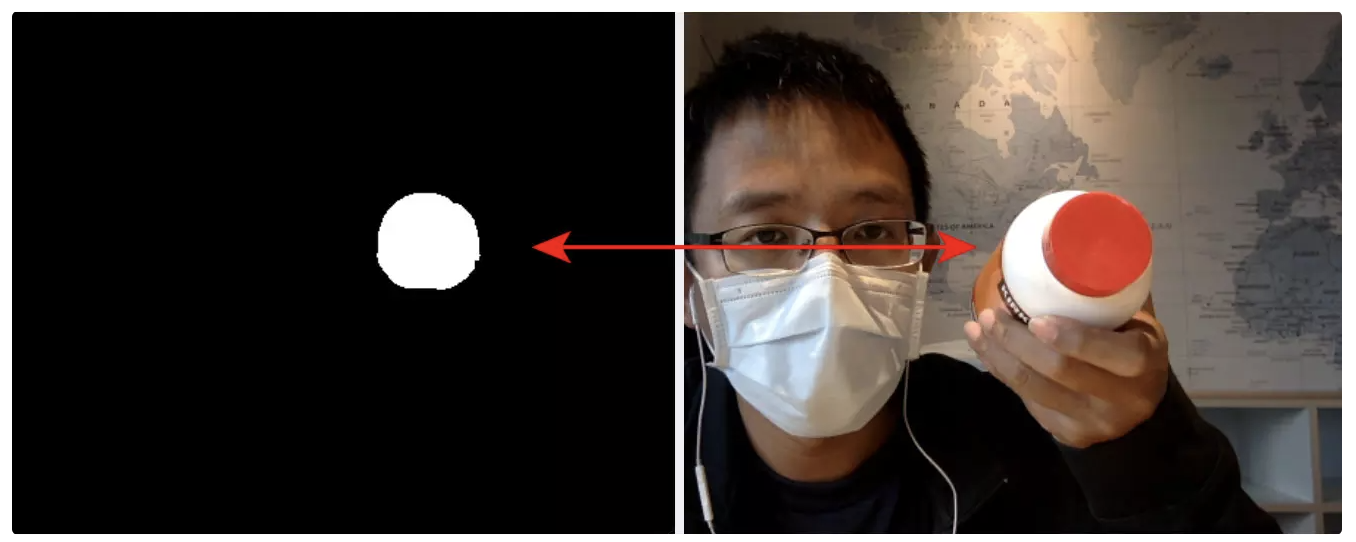

In [2]:
import cv2
import numpy as np

# 設定顏色範圍的下限 (H: 30, S: 40, V: 200)
lower = np.array([30, 40, 200])  # 轉換成 NumPy 陣列，範圍稍微變小 (H: 55->30, S: 70->40, V: 252->200)
# 設定顏色範圍的上限 (H: 90, S: 100, V: 255)
upper = np.array([90, 100, 255]) # 轉換成 NumPy 陣列，範圍稍微加大 (H: 70->90, S: 80->100, V: 252->255)

# 開啟攝影機
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

while True:
    # 讀取攝影機影像
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    
    # 縮小尺寸，加快處理速度
    img = cv2.resize(img, (640, 360))
    
    # 使用 inRange 函數來取得顏色範圍內的像素
    output = cv2.inRange(img, lower, upper)
    
    # 設定膨脹與侵蝕的參數，使用矩形結構元素，大小為 11x11
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    
    # 膨脹影像，消除雜訊
    output = cv2.dilate(output, kernel)
    
    # 縮小影像，還原大小
    output = cv2.erode(output, kernel)
    
    # 顯示結果影像
    cv2.imshow('oxxostudio', output)
    
    # 按下 q 鍵停止
    if cv2.waitKey(1) == ord('q'):
        break

# 釋放攝影機資源並關閉所有視窗
cap.release()
cv2.destroyAllWindows()

##### 取得顏色範圍的輪廓座標 
取得特定顏色後，使用 findContours 抓取顏色範圍的輪廓座標，並透過 for 迴圈印出座標。

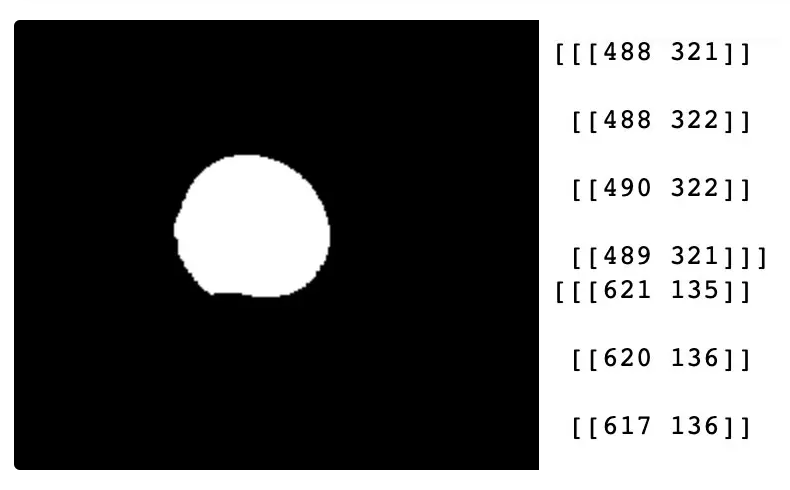

In [ ]:
import cv2
import numpy as np
lower = np.array([30,40,200])
upper = np.array([90,100,255])
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    img = cv2.resize(img,(640,360))
    output = cv2.inRange(img, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    output = cv2.dilate(output, kernel)
    output = cv2.erode(output, kernel)

    # cv2.findContours 抓取顏色範圍的輪廓座標
    # cv2.RETR_EXTERNAL 表示取得範圍的外輪廓座標串列，cv2.CHAIN_APPROX_SIMPLE 為取值的演算法
    contours, hierarchy = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 使用 for 迴圈印出座標長相
    for contour in contours:
        print(contour)

    cv2.imshow('oxxostudio', output)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

##### 根據輪廓座標，繪製形狀 
取得輪廓的座標後，使用 contourArea 計算輪廓座標包覆的面積，如果面積大於 300 再進行繪圖 ( 避免偵測到背景太小的區域 )，繪圖使用 line 的方法，將每一個座標點連在一起。

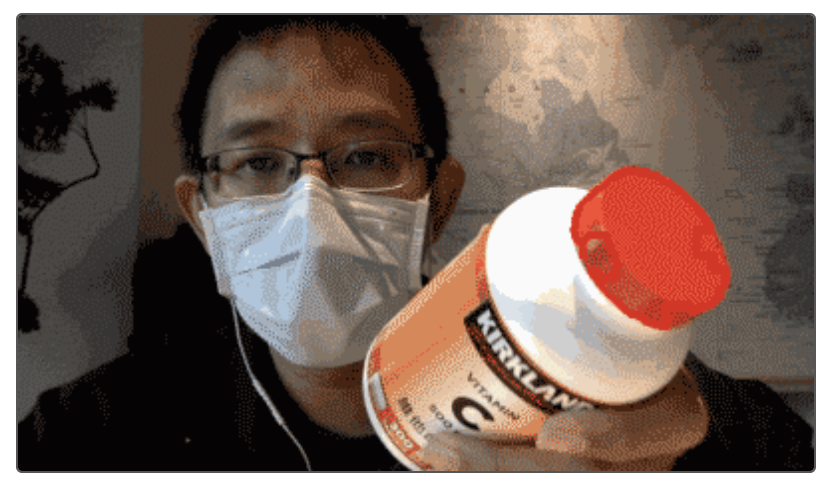

In [4]:
import cv2
import numpy as np
lower = np.array([30,40,200])
upper = np.array([90,100,255])
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    img = cv2.resize(img,(640,360))
    output = cv2.inRange(img, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    output = cv2.dilate(output, kernel)
    output = cv2.erode(output, kernel)

    contours, hierarchy = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)    # 取得範圍內的面積
        color = (0,0,255)                  # 設定外框顏色
        # 如果面積大於 300 再標記，避免標記到背景中太小的東西
        if(area > 300):
            for i in range(len(contour)):
                if i>0 and i<len(contour)-1:
                    # 從第二個點開始畫線
                    img = cv2.line(img, (contour[i-1][0][0], contour[i-1][0][1]), (contour[i][0][0], contour[i][0][1]), color, 3)
                elif i == len(contour)-1:
                    # 如果是最後一個點，與第一個點連成一線
                    img = cv2.line(img, (contour[i][0][0], contour[i][0][1]), (contour[0][0][0], contour[0][0][1]), color, 3)

    cv2.imshow('oxxostudio', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

如果想用四邊形標記特定顏色，可以使用 boundingRect 取得輪廓的 xy 座標和長寬尺寸，再透過 rectangle 繪製四邊形。

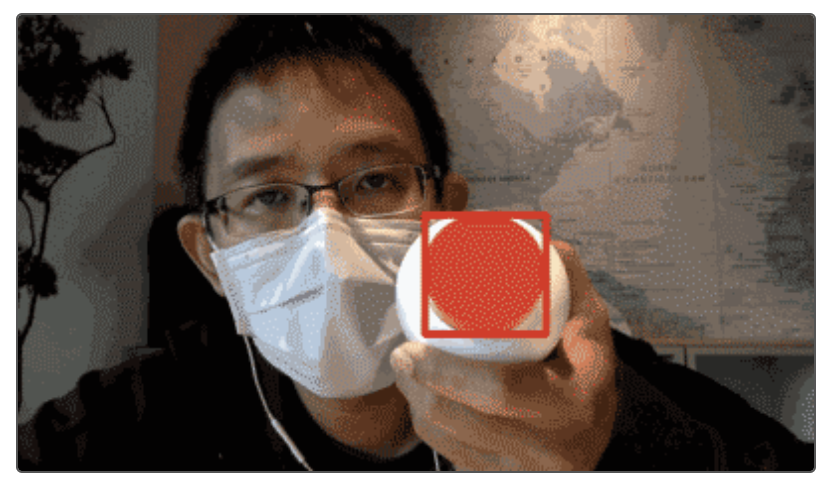

In [5]:
import cv2
import numpy as np
lower = np.array([30,40,200])   # 轉換成 NumPy 陣列，範圍稍微變小 ( 55->30, 70->40, 252->200 )
upper = np.array([90,100,255])  # 轉換成 NumPy 陣列，範圍稍微加大 ( 70->90, 80->100, 252->255 )
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    img = cv2.resize(img,(640,360))
    output = cv2.inRange(img, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    output = cv2.dilate(output, kernel)
    output = cv2.erode(output, kernel)
    contours, hierarchy = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        color = (0,0,255)
        if(area > 300):
            x, y, w, h = cv2.boundingRect(contour)                      # 取得座標與長寬尺寸
            img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)  # 繪製四邊形

    cv2.imshow('oxxostudio', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

##### 同時追蹤並標記多種顏色 
運用同樣的做法，只要知道顏色範圍，就可以追蹤各種不同的顏色，下方的程式碼執行後，可以追蹤兩種不同的顏色。

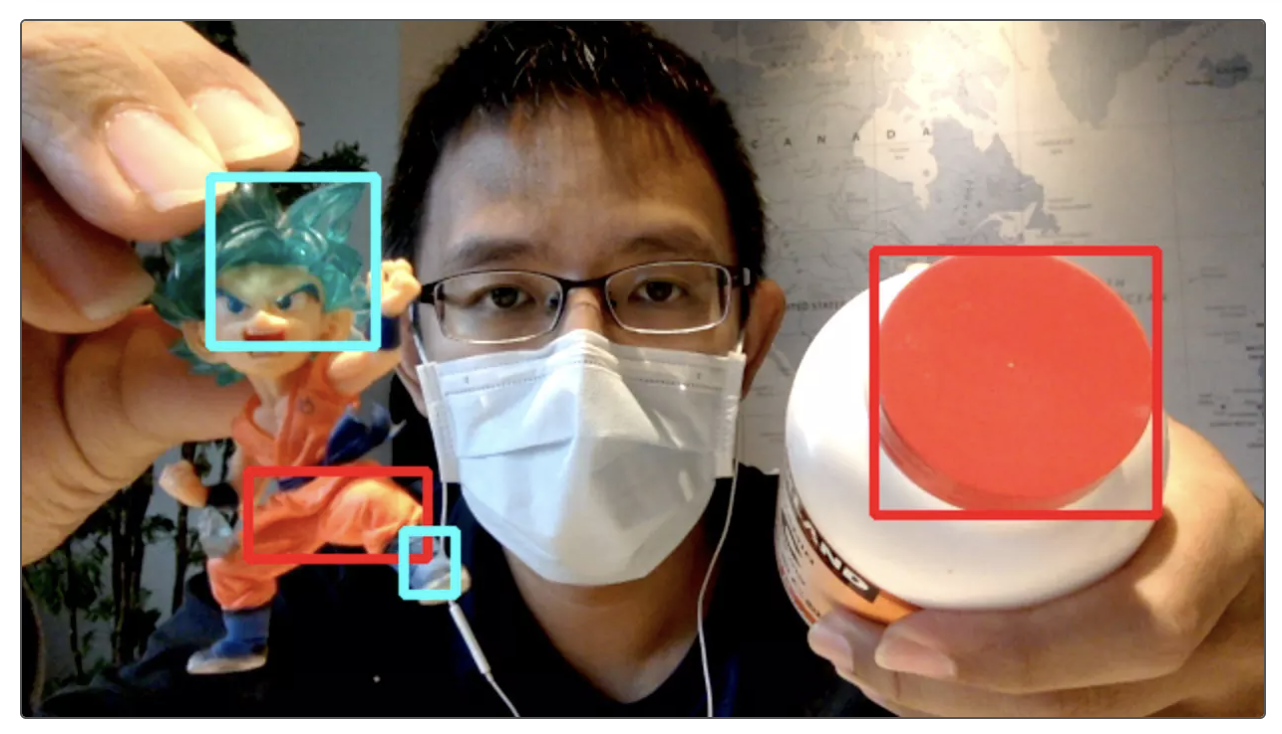

In [6]:
import cv2
import numpy as np
lower = np.array([30,40,200])
upper = np.array([90,100,255])

blue_lower = np.array([90,100,0])     # 設定藍色最低值範圍
blue_upper = np.array([200,160,100])  # 設定藍色最高值範圍

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    ret, img = cap.read()
    if not ret:
        print("Cannot receive frame")
        break
    img = cv2.resize(img,(640,360))
    output = cv2.inRange(img, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    output = cv2.dilate(output, kernel)
    output = cv2.erode(output, kernel)
    contours, hierarchy = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    for contour in contours:
        area = cv2.contourArea(contour)
        color = (0,0,255)
        if(area > 300):
            x, y, w, h = cv2.boundingRect(contour)
            img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)

    # 設定選取藍色的程式
    blue_output = cv2.inRange(img, blue_lower, blue_upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    blue_output = cv2.dilate(blue_output, kernel)
    blue_output = cv2.erode(blue_output, kernel)
    contours, hierarchy = cv2.findContours(blue_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        color = (255,255,0)
        if(area > 300):
            x, y, w, h = cv2.boundingRect(contour)
            img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)

    cv2.imshow('oxxostudio', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()